In [41]:
import numpy as np
import xsim
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

from atm.flight.operation import Operation
from atm.flight.flight import DUMMY_FLIGHT_RECAT
from atm.separation import recat

from atm.simulator.generator import RealTimeScenarioGenerator
from atm.simulator.stripe import Stripe


In [75]:
from IPython.display import clear_output
from time import sleep
from docplex.mp.model import Model
from typing import Tuple, Optional, Union
from atm.flight.flight import Flight
from atm.flight.scenario import Scenario
from atm.separation.base import Separation

In [70]:
parameter = dict(
    interval=180,
    window=dict(
        min=int(10*60),
        shift=int(3*60),
    ),
    mode="M",
    margin=dict(
        min=1500,
        shift=int(5*60)
    ),
)

MERGIN = 10
separation = recat.TBS

In [71]:
def fcfs_assign(stripes):
    last_vol = DUMMY_FLIGHT_RECAT
    last_time = last_vol.de
    for stripe in stripes:
        vol = stripe.vol
        sep = separation(last_vol, vol)
        time = np.max([last_time + sep + MERGIN, vol.ready])

        stripe.assign_time(time)
        stripe.assign_rwy("34L")

        last_vol = vol
        last_time = time

    return stripes


In [ ]:
def ix(vol1: Flight, vol2: Optional[Flight] = None) -> Union[str, Tuple[str, str]]:
    if vol2 is None:
        return vol1.code

    return vol1.code, vol2.code

In [ ]:
def build_model(vols: Scenario, sep: Separation) -> Tuple[Model, tuple, tuple]:
    M: int = 1000  # big-M

    m = Model("CADM")

    # define variables
    # assign time
    ts = {
        vol.code: m.integer_var(lb=vol.ready, ub=vol.due, name=f"T_{vol.code}")
        for vol in vols
    }
    # leader flag
    # y = 1 if vol1 leads vol2
    ys = {
        ix(vol1, vol2): m.binary_var(name=f"y_{vol1.code}_{vol2.code}")
        for vol1 in vols
        for vol2 in vols
        if not vol1 == vol2
    }

    # constrains
    [
        m.add_constraint(ts[ix(vol2)] >= ts[ix(vol1)] + sep(vol1, vol2) - M * (1 - ys[ix(vol1, vol2)]))
        for vol1 in vols
        for vol2 in vols
        if not vol1 == vol2
    ]

    [
        m.add_constraint(ys[ix(vol1, vol2)] + ys[ix(vol2, vol1)] == 1)
        for vol1 in vols
        for vol2 in vols
        if vol1 < vol2
    ]

    m.minimize(m.sum([
        ts[ix(vol)] - vol.ready
        for vol in vols
    ]))

    return m, ts, ys

In [ ]:
def opt_assign(time, stripes):
    scenario = Scenario([
        vol.vol for vol in stripes if vol.de >= time + 5 * 60
    ])
    m, ts, ys = build_model(scenario, separation)
    m.solve()
    for stripe, t in zip(stripes, ts):
        stripe.set_time(t)


In [72]:
def draw(time, stripes):
    time_shift = time - 5 * 60
    num_vol = len(stripes)
    height = 1
    timespan = 60  # min
    timelimit = 10 # min

    if num_vol == 0:
        fig_height = 1
    else:
        fig_height = num_vol * 0.5 + 0.5
    fig, ax = plt.subplots(figsize=(20, fig_height))
    for i, vol in enumerate(stripes):
        i = num_vol - i - 1
        tde = vol.de
        tto = vol.to
        window_color = "r" if vol.ope == Operation.A else "b"
        window = ptc.Rectangle(
            (tde, height*(i+0.1)), tto - tde, height*0.8, color=window_color, alpha=0.2
        )
        window_border = ptc.Rectangle(
            (tde, height*(i+0.1)), tto - tde, height*0.8, color="k", alpha=1, fill=False, linewidth=2
        )
        tasign = vol.time
        ax.plot([tasign, tasign], [i*height, (i+1)*height], color=window_color, linewidth=3)
        ax.add_patch(window)
        ax.add_patch(window_border)

        code = vol.vol.code
        plt.text(tto+30, height*(i+0.3), code+"("+str(vol.cat)+")"+"|"+vol.rwy, fontsize=30)

    for i in range(num_vol - 1):
        vol1 = stripes[i].vol
        vol2 = stripes[i+1].vol
        tassign = stripes[i].time
        sep = separation(vol1, vol2)

        for k in range(num_vol):
            if i > k:
                continue
            k = num_vol - k - 1
            window_sep = ptc.Rectangle(
                (tassign, height*+k), sep, height, color="k", alpha=0.1
            )
            ax.add_patch(window_sep)

    timelimit = time + timelimit * 60
    min_height = height * (1 if num_vol == 0 else num_vol)
    ax.plot([time, time], [0, min_height], linewidth=3, linestyle="-", color="orange")
    ax.plot([timelimit, timelimit], [0, min_height], linewidth=3, linestyle="--", color="orange")
    ax.set_xlim(time_shift, time + timespan * 60)
    ax.set_ylim(0, min_height)
    xticks = np.arange((time + timespan * 60) // 300 + 1) * 300
    xticks = xticks[xticks >= time_shift]
    ax.set_xticks(xticks)
    ax.set_yticks([i*height for i in range(num_vol+1)])
    plt.grid()
    plt.show()


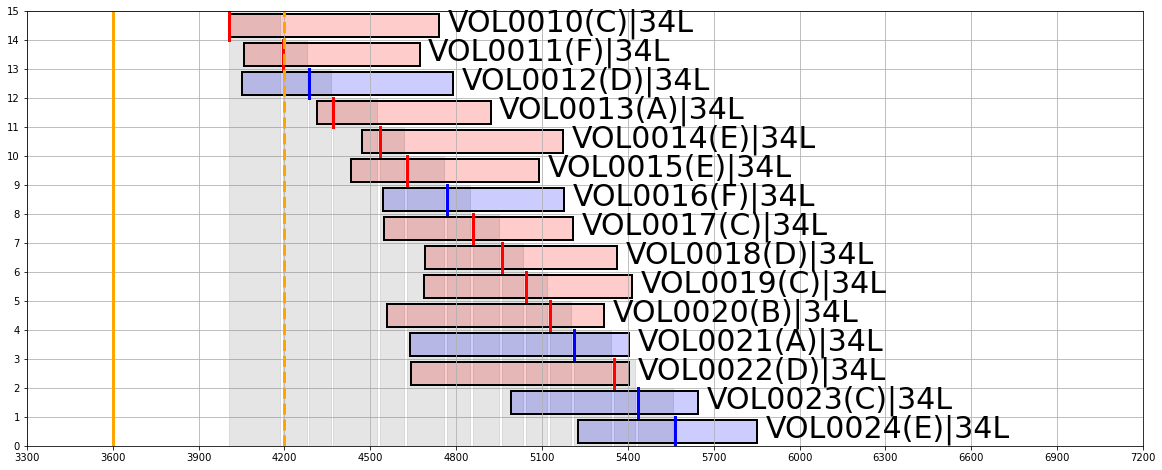

In [73]:
dt = 1     # sec
due = 60   # min
queue = []

rgen = RealTimeScenarioGenerator(parameter)
for time in xsim.generate_step_time(due * 60, dt):
    queue = [vol for vol in queue if vol.time >= time - 5 * 60]

    vol = rgen(dt=dt)
    if vol is not None:
        vol = Stripe(vol)
        queue.append(vol)
        # queue = fcfs_assign(queue)
        queue = opt_assign(time, queue)

    if (time % 10) == 0:
        clear_output()
        draw(time, queue)

    sleep(1/200)